**SVM**

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics


def train_svm(values, labels, kernel, degree):
    classifier = svm.SVC(kernel=kernel, degree=degree, gamma='scale')
    classifier.fit(values, labels)
    return classifier


def plot_svm(clf, values, labels):
    h = 0.2
    x_min, x_max = values[:, 0].min() - 1, values[:, 0].max() + 1
    y_min, y_max = values[:, 1].min() - 1, values[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)

    support_vectors = clf.support_vectors_

    plt.scatter(values[:, 0], values[:, 1], c=labels, cmap=plt.cm.Paired)
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], c='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

    plt.show()


def process_data(kernel, degree=1):
    trained_clf = train_svm(values, labels, kernel, degree)
    plot_svm(trained_clf, values, labels)

In [12]:
dataset = pd.read_csv('blobs2.csv')
values = dataset.drop('label', axis=1).to_numpy()
labels = dataset['label'].to_numpy()

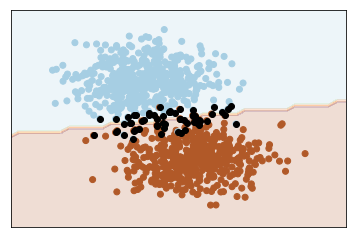

In [13]:
process_data('linear')

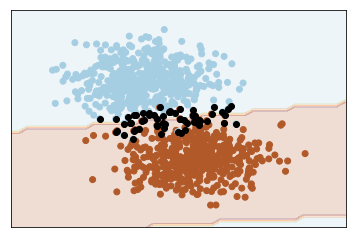

In [14]:
process_data('poly', 2)

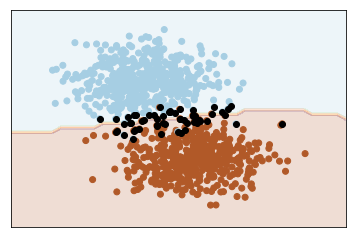

In [15]:
process_data('poly', 3)

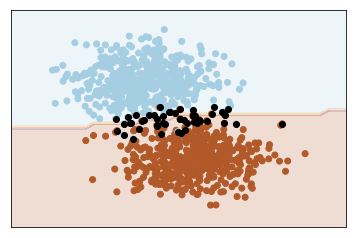

In [16]:
process_data('poly', 5)

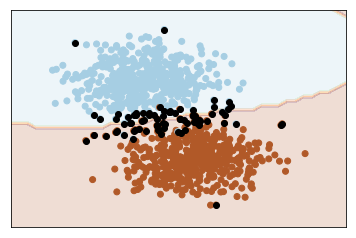

In [17]:
process_data('rbf')

In [18]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


def train_svm(values, labels, kernel, degree):
    classifier = svm.SVC(kernel=kernel, degree=degree, gamma='scale')
    classifier.fit(values, labels)
    return classifier


def svm_process_data(training_values, training_labels, test_values, test_labels, kernel, degree=1):
    start_time = time.time()

    trained_clf = train_svm(training_values, training_labels, kernel, degree)
    predictions = trained_clf.predict(test_values)
    accuracy = metrics.accuracy_score(test_labels, predictions)
    print("SVM accuracy: " + str(accuracy))

    end_time = time.time()
    print("SVM time: " + str(end_time - start_time) + " seconds")


def random_forest_process_data(training_values, training_labels, test_values, test_labels):
    start_time = time.time()

    scaler = StandardScaler()
    train_x = scaler.fit_transform(training_values)
    test_x = scaler.transform(test_values)
    classifier = RandomForestClassifier(n_estimators=100)
    classifier.fit(train_x, training_labels)
    predictions = classifier.predict(test_x)
    accuracy = metrics.accuracy_score(test_labels, predictions)
    print("Random forest accuracy: " + str(accuracy))

    end_time = time.time()
    print("Random forest time: " + str(end_time - start_time) + " seconds")


def process_dataset(filename):
    dataset = pd.read_csv(filename)
    values = dataset.drop('label', axis=1).to_numpy()
    labels = dataset['label'].to_numpy()
    training_values, test_values, training_labels, test_labels = train_test_split(values, labels, test_size=0.2)

    svm_process_data(training_values, training_labels, test_values, test_labels, 'linear')
    random_forest_process_data(training_values, training_labels, test_values, test_labels)

In [19]:
process_dataset('cancer.csv')

SVM accuracy: 0.9298245614035088
SVM time: 0.9319612979888916 seconds
Random forest accuracy: 0.9736842105263158
Random forest time: 0.15096735954284668 seconds


In [20]:
process_dataset('spam.csv')

SVM accuracy: 0.9348534201954397
SVM time: 213.46241641044617 seconds
Random forest accuracy: 0.9641693811074918
Random forest time: 0.46788501739501953 seconds


**Bayesian Classifier**

**Naive Bayes with Gaussian features**

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split


def generate_data(class_data_dic, training_values, training_labels):
    first_one = True
    first_zero = True
    for i in range(len(training_labels)):
        tmp = training_values[i, :].reshape(training_values[i, :].shape[0], 1)
        if training_labels[i] == 1:
            if first_one:
                class_data_dic[1] = tmp
                first_one = False
            else:
                class_data_dic[1] = np.append(class_data_dic[1], tmp, axis=1)
        elif training_labels[i] == 0:
            if first_zero:
                class_data_dic[0] = tmp
                first_zero = False
            else:
                class_data_dic[0] = np.append(class_data_dic[0], tmp, axis=1)
    return class_data_dic


def likelihood(x, mean, sigma):
    return np.exp(-(x - mean) ** 2 / (2 * sigma ** 2)) * (1 / (np.sqrt(2 * np.pi) * sigma))


class NaiveBayesClassifier:
    def __init__(self):
        self.class_data_dic = {}

    def fit(self, training_values, training_labels):
        self.training_values = training_values
        self.training_labels = training_labels
        self.class_data_dic[0] = np.array([[]])
        self.class_data_dic[1] = np.array([[]])
        self.class_data_dic = generate_data(self.class_data_dic, self.training_values, self.training_labels)
        self.class_data_dic[0] = self.class_data_dic[0].T
        self.class_data_dic[1] = self.class_data_dic[1].T
        self.mean0 = np.mean(self.class_data_dic[0], axis=0)
        self.mean1 = np.mean(self.class_data_dic[1], axis=0)
        self.std0 = np.std(self.class_data_dic[0], axis=0)
        self.std1 = np.std(self.class_data_dic[1], axis=0)

    def posterior_probability(self, values, training_values_class, mean_, std_):
        product = np.prod(likelihood(values, mean_, std_), axis=1)
        product = product * (len(training_values_class) / len(self.training_values))
        return product

    def predict(self, test_values):
        self.p_1 = self.posterior_probability(test_values, self.class_data_dic[1], self.mean1, self.std1)
        self.p_0 = self.posterior_probability(test_values, self.class_data_dic[0], self.mean0, self.std0)
        return 1 * (self.p_1 > self.p_0)


def plot_roc(tpr, fpr, title_text=""):
    plt.plot(fpr, tpr)
    plt.title(title_text)
    plt.show()


def process_dataset(filename, first_label):
    dataset = pd.read_csv(filename)
    values = dataset.drop('label', axis=1).to_numpy()
    initial_labels = dataset['label']
    labels = []
    for l in initial_labels:
        if l == first_label:
            labels.append(0)
        else:
            labels.append(1)
    labels = np.asarray(labels)

    training_values, test_values, training_labels, test_labels = train_test_split(values, labels, test_size=0.2)
    nb = NaiveBayesClassifier()
    nb.fit(training_values, training_labels)
    y_pred = nb.predict(test_values)
    print(metrics.accuracy_score(test_labels, y_pred))
    fpr, tpr, _ = metrics.roc_curve(test_labels, nb.p_1 - nb.p_0)
    plot_roc(tpr, fpr)

0.9210526315789473


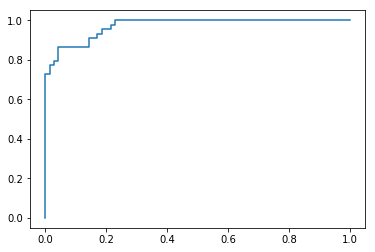

In [26]:
process_dataset('cancer.csv', 'B')

0.8154180238870793


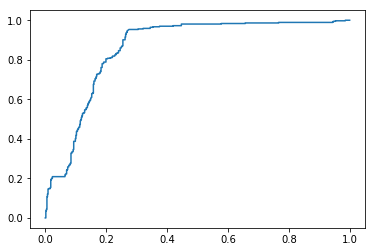

In [27]:
process_dataset('spam.csv', 0)

**Naive Bayes with discrete features**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn import metrics
from sklearn.model_selection import train_test_split


def stem_text(stemmer, text):
    return [stemmer.stem(word) for word in word_tokenize(text)]


def preprocess_data(values):
    texts = values.T[0]

    stemmer = PorterStemmer()
    unique_words = set()
    for text in texts:
        words = stem_text(stemmer, text)
        words = set(map(lambda word: word.lower(), [word for word in words if word.isalpha()]))
        unique_words |= words

    vectors = []
    for text in texts:
        words = stem_text(stemmer, text)
        v = {word: 0 for word in unique_words}
        for word in filter(lambda word: word in unique_words, words):
            v[word] += 1
        vectors.append(v)
    return vectors


def build_feature_map(values):
    features = {word: {} for word in values[0]}
    # all rows in values have the same arrangement of words in the dictionary anyway
    for word in values[0]:
        word_counts = {}
        for row in values:
            word_counts[row[word]] = word_counts.get(row[word], 0) + 1
        for cnt in word_counts:
            features[word][cnt] = word_counts[cnt]
    return features


def likelihood(i, x, label_features, features, k):
    return np.log((label_features[i].get(x[i], 0) + 1) / (features[i].get(x[i], 0) + k))


class NaiveBayesClassifier:
    def __init__(self):
        self.labeled = {}
        self.label_features = {}

    def fit(self, training_values, training_labels):
        self.training_values = training_values
        self.training_labels = training_labels
        self.features = build_feature_map(training_values)
        self.labeled[0] = np.array([])
        self.labeled[1] = np.array([])
        for j in range(len(self.training_labels)):
            if self.training_labels[j] == 0:
                self.labeled[0] = np.append(self.labeled[0], training_values[j])
            else:
                self.labeled[1] = np.append(self.labeled[1], training_values[j])
        self.label_features[0] = build_feature_map(self.labeled[0])
        self.label_features[1] = build_feature_map(self.labeled[1])

    def predict(self, test_values):
        probs = []

        for label in range(2):
            lab_features = self.label_features[label]
            val_prob = []
            for i in range(len(test_values)):
                x = test_values[i]
                prob = 0
                for column in x:
                    prob += math.log((lab_features[column].get(x[column], 0) + 1) /
                                     (self.features[column].get(x[column], 0) + len(self.features.keys())))
                prob += math.log(len(self.labeled[label]) / len(self.training_values))
                val_prob.append(prob)
            probs.append(val_prob)
        return probs


def plot_roc(tpr, fpr, title_text=""):
    plt.plot(fpr, tpr)
    plt.title(title_text)
    plt.show()


def process_dataset(filename, first_label):
    dataset = pd.read_csv(filename)
    values = dataset.drop('label', axis=1).to_numpy()
    initial_labels = dataset['label']
    labels = []
    for l in initial_labels:
        if l == first_label:
            labels.append(0)
        else:
            labels.append(1)
    labels = np.asarray(labels)
    vectors = preprocess_data(values)

    training_values, test_values, training_labels, test_labels = train_test_split(vectors, labels, test_size=0.2)

    nb = NaiveBayesClassifier()
    nb.fit(training_values, training_labels)
    y_pred = nb.predict(test_values)
    sms_fpr, sms_tpr, _ = metrics.roc_curve(test_labels, (np.array(y_pred[1]) - np.array(y_pred[0])))
    plot_roc(sms_tpr, sms_fpr)


showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


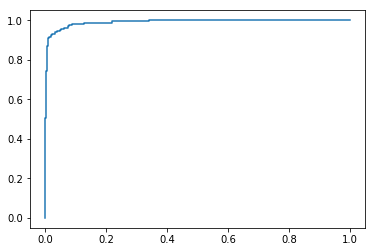

In [3]:
nltk.download()
process_dataset('smsspam.csv', 'ham')